# Overview
This Jupyter Notebook serves as our prototype of projection and reprojection functions. Codes in it should be executed in a specific order and conditions with a cooperation of our 2D segmentation codes. Basically, this notebook will load a model, take 4 rgbd views for it and export them to images to be passed into the 2D segmentation model. Then, after the 2D segmentation finishes, we read the segmentation masks and reproject them back into 3D to form a point cloud.

In [1]:
import numpy as np 
import os
import open3d as o3d
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import time
from scipy.spatial import cKDTree
from functools import reduce

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Function Definition
Here we have some function definition and packaging to use with Open3D.

In [2]:
def read_mesh(filename:str):
    #pcd = o3d.io.read_triangle_mesh(filename, True)
    pcd = o3d.io.read_triangle_model(filename, True)
    return pcd
def read_point_cloud(filename:str):
    pcd = o3d.io.read_point_cloud(filename)
    return pcd

In [3]:
def render(geometries):
    o3d.visualization.draw_geometries(geometries)

In [4]:
# side effect: will set renderer_pc's extrinsic camera
def get_view(renderer_pc, intrinsic, model, center, eye, up=[0,1,0], extrinsic=None, img_width=400, img_height=500):


    # grey = o3d.visualization.rendering.MaterialRecord()
    # grey.base_color = [0.7, 0.7, 0.7, 1.0]
    # grey.shader = "defaultLit"
    
    material = o3d.visualization.rendering.MaterialRecord()
    # texture = np.asarray(model.colors).copy()
    # texture = texture.astype(np.float32)
    # texture = o3d.geometry.Image(texture)
    # material.albedo_img = texture
    material.aspect_ratio = 1.0
    material.shader = "defaultLit"



    # renderer_pc.scene.scene.set_sun_light([-1, -1, -1], [1.0, 1.0, 1.0], 100000)
    renderer_pc.scene.set_lighting(renderer_pc.scene.LightingProfile.NO_SHADOWS, (0, 0, 0))
    renderer_pc.scene.scene.enable_sun_light(True)

    renderer_pc.scene.add_geometry("model", model, material)
    
    # # just for reference 
    # axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=([0., 0., 0.]))
    # renderer_pc.scene.add_geometry("axis", axis, material)

    
    # for triangle meshes
    # renderer_pc.scene.add_model("model", model)

    # Optionally set the camera field of view (to zoom in a bit)
    vertical_field_of_view = 30  # between 5 and 90 degrees
    aspect_ratio = img_width / img_height  # azimuth over elevation
    near_plane = 0.05
    far_plane = 50.0
    fov_type = o3d.visualization.rendering.Camera.FovType.Vertical
    # renderer_pc.scene.camera.set_projection(vertical_field_of_view, aspect_ratio, near_plane, far_plane, fov_type)
    
    renderer_pc.scene.camera.set_projection(intrinsic.intrinsic_matrix, near_plane, far_plane, img_width, img_height)

    # Look at the origin from the front (along the -Z direction, into the screen), with Y as Up.
    # camera orientation
    # extrinsic = lookat(np.asarray(center), np.asarray(eye), np.asarray(up))
    renderer_pc.scene.camera.look_at(center, eye, up)
    if extrinsic is not None:
        renderer_pc.setup_camera(intrinsic, extrinsic)
    # renderer_pc.setup_camera(intrinsic, extrinsic)

    depth_image = np.asarray(renderer_pc.render_to_depth_image(True) )
    image = np.asarray(renderer_pc.render_to_image())


    # plt.imshow(depth_image)
    renderer_pc.scene.remove_geometry("model")
    # renderer_pc.scene.remove_geometry("axis")
    return (image, depth_image, renderer_pc.scene.camera.get_view_matrix())

In [5]:
def lookat(center, eye, up):
    f = (eye - center)
    f /= np.linalg.norm(f)
    
    r = np.cross(up, f)
    r /= np.linalg.norm(r)
    
    u = np.cross(f, r)
    u /= np.linalg.norm(u)

    view_matrix = np.eye(4)
    view_matrix[:3, :3] = np.column_stack((r, u, -f))
    view_matrix[:3, 3] = -np.dot(np.column_stack((r, u, -f)), eye)
    
    return view_matrix

In [6]:
def flip(matrix):
    result = np.copy(matrix)
    result[1:3,:] = -1 * result[1:3,:]
    return result

In [7]:
def rgbd_to_pointcloud(rgbd, intrinsic, extrinsic_camera):
    # extrinsic_camera = np.array(extrinsic_camera)
    # extrinsic_camera = np.linalg.inv(extrinsic_camera)
    pcd =  o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic, flip(extrinsic_camera))
    # Flip it, otherwise the pointcloud will be upside down
    #pcd.transform([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
    return pcd
def downsample_rescale(pcd, voxel_size=0.00001, scale=10000):
    downsampled_pc = pcd.voxel_down_sample(voxel_size)
    # use mean as the center for now
    a1 = np.asarray(downsampled_pc.points)
    scaled_downsampled_pc = downsampled_pc.scale(scale, a1.mean(0))
    return scaled_downsampled_pc

In [8]:
def downsample(pcd, voxel_size=0.00001):
    downsampled_pc = pcd.voxel_down_sample(voxel_size)
    return downsampled_pc

In [9]:
def read_segmentation(file_name, depth):
    # for read npy files
    rgb = np.load(file_name).astype(np.uint8)
    rgb = o3d.geometry.Image(rgb)
    ## for read image files
    #rgb = o3d.io.read_image(file_name)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        rgb, o3d.geometry.Image(depth), convert_rgb_to_intensity=False, depth_scale=1)
    return rgbd_image

## Renderer Initialization and Model Loading

In this part, we initialize a headless renderer of Open3d, define the resolution of images and the intrinsic camera matrix that will share among all cameras. Headless rendering has a different API with the Visualization(see reference: https://stackoverflow.com/questions/69696354/capture-depth-image-without-opening-visualizer-in-open3d). The resolution of images will affect the sampling resolution of the point cloud we create. A specific model is also loaded here. If you want to load another model, the parameter in read_mesh should be the path to your mesh.

In [10]:
img_width, img_height = (1920, 1080)
renderer_pc = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)
intrinsic =  o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.Kinect2ColorCameraDefault)




[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7f7c59943010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


In [10]:
model = read_point_cloud('/home/demoy/3dProjection/confidence_search/k+weighted+backgroundThreshold+smooth/0500_cdcl_pcd_2100_500_result_1058.ply')
o3d.visualization.draw_geometries([model ] )

In [43]:
# model = read_mesh("THuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0047/0047.obj")

# move the model to the center of the cooridinate system
model = read_point_cloud('/home/demoy/3dProjection/THuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0047/pcd_0.ply')
points = np.asarray(model.points)
points /= 225
points -= points.mean(0)
model.transform(np.array([[1,0,0,0], 
                        [0,1,0,0],
                        [0,0,1,0],
                        [0,0,0,1]]))
model.normals.clear()

# o3d.visualization.draw_geometries([ model, o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0., 0., 0.])])


mean_cov = model.compute_mean_and_covariance()
mean = mean_cov[0]
covariance_matrix = mean_cov[1]

eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

# 特征向量与特征值关联，并按特征值排序（特征值最大的对应主要的方向）
eig_index = np.argsort(eigen_values)[::-1]
principal_axes = eigen_vectors[:, eig_index]
# principal_axes = principal_axes.transpose()

principal_axes[:,[0,1]] = principal_axes[:,[1,0]]

if principal_axes[:, 0] [0]< 0:
    principal_axes[:,0]*= -1
if principal_axes[:,1][1] < 0:
    principal_axes[:,1]*= -1
if principal_axes[:,2][2] < 0:
    principal_axes[:,2]*= -1
# print(principal_axes)
new_z_axis = np.array([principal_axes[:,2][0], 0, principal_axes[:,2][1]])

# 定义原始的z轴向量和旋转后的向量v
z_axis = np.array([0, 0, 1])


# 计算旋转轴（cross product）
rotation_axis = np.cross(z_axis, new_z_axis)
# print(rotation_axis)
# 计算旋转角度（dot product和arccos）
cos_theta = np.dot(z_axis, new_z_axis) / (np.linalg.norm(z_axis) * np.linalg.norm(new_z_axis))
angle = np.arccos(cos_theta)

# 计算旋转矩阵（Rodrigues' rotation formula）
K = np.array([
    [0, -rotation_axis[2], rotation_axis[1]],
    [rotation_axis[2], 0, -rotation_axis[0]],
    [-rotation_axis[1], rotation_axis[0], 0]
])
identity_matrix = np.eye(3)
rotation_matrix = identity_matrix + np.sin(-angle) * K + (1 - np.cos(-angle)) * (K @ K)

# 使用Open3D可视化原点云和主轴方向
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.5, origin=mean)
mesh_frame.rotate(principal_axes, center=mean)
coorinate = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0., 0., 0.])
model.rotate(principal_axes.transpose(), center=mean)
o3d.visualization.draw_geometries([model,coorinate ] )

## Projection
The main part for projection. Given a center and an eye position, get_view will return the RGB image and the depth image from that view built by the lookAt function. Extrinsic matrice are also returned and will be used to recontruct point clouds. Here in the prototype, we only use four fixed views. Actually, from our experiment, side views are always not reliable and more views are not necessarily better due to the matching problem.

The RGB images are saved as files and passed to the 2D segmentation pipeline.

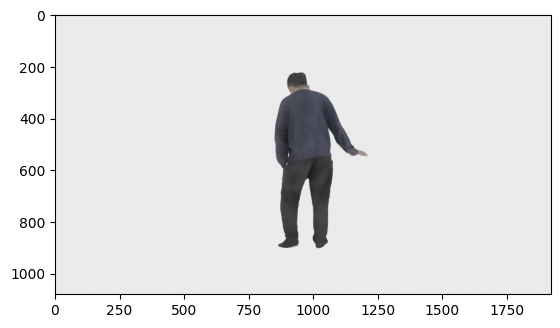

In [12]:
image, depth, extrinsic = get_view(renderer_pc, intrinsic, model, center=[0,0,0], eye=[0,0,3], up=[0,1,0],
                                   img_width=img_width, img_height=img_height)
plt.imshow(image)


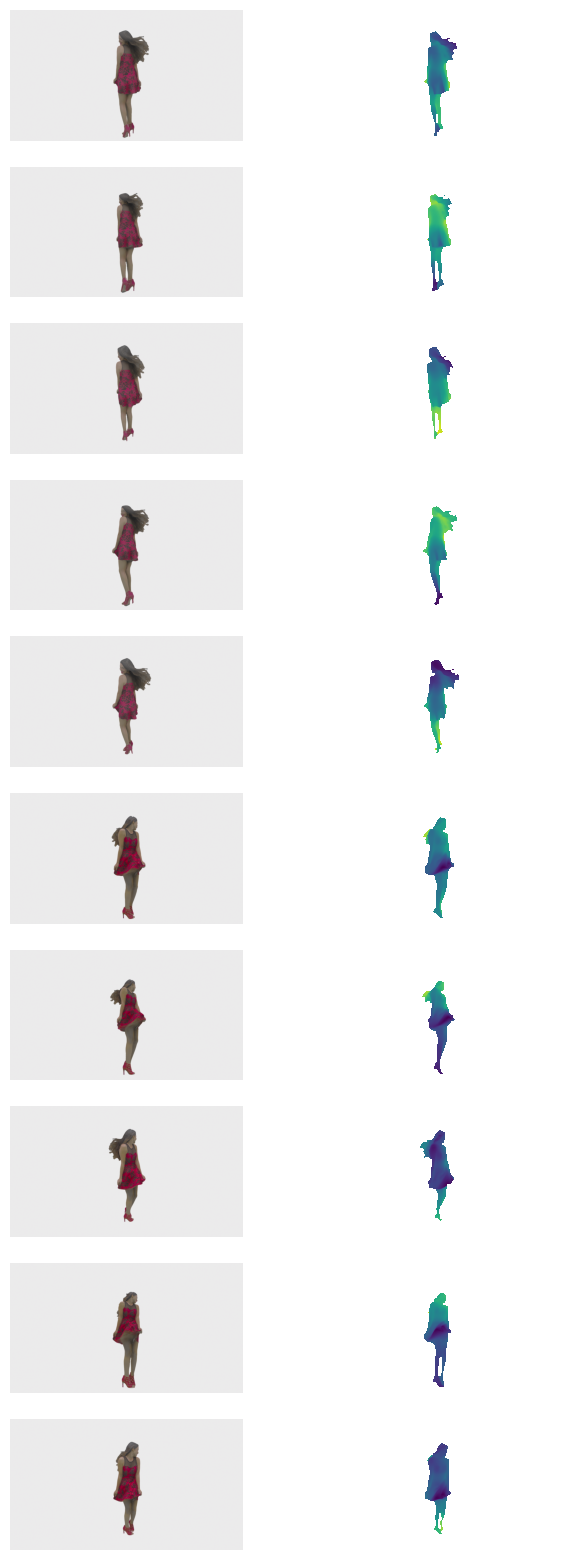

In [19]:
images = []
depths = []
extrinsics = []

radius = 0.5
eyes = [
    [0,0,1.35],
    # [1*radius,0,1.35],
    # [0,1*radius,1.35],
    # [-1*radius,0,1.35],
    # [0,-1*radius,1.35],
    [0.71*radius,-0.71*radius,1.35],
    [0.71*radius,0.71*radius,1.35],
    [-0.71*radius,-0.71*radius,1.35],
    [-0.71*radius,0.71*radius,1.35],
    
    [0,0,-1.35],
    # [1*radius,0,-1.35],
    # [0,1*radius,-1.35],
    # [-1*radius,0,-1.35],
    # [0,-1*radius,-1.35],
    [0.71*radius,-0.71*radius,-1.35],
    [0.71*radius,0.71*radius,-1.35],
    [-0.71*radius,-0.71*radius,-1.35],
    [-0.71*radius,0.71*radius,-1.35],

]

for i in range(len(eyes)):
    image, depth, extrinsic = get_view(renderer_pc, intrinsic, model, center=[0,0,0], eye=eyes[i], up=[0,1,0],
                                   img_width=img_width, img_height=img_height)
    images.append(image)
    depths.append(depth)
    extrinsics.append(extrinsic)



fig, axs = plt.subplots(len(eyes), 2, figsize=(8, 20))
for i in range(len(eyes)):
    axs[(i)][0].imshow(images[i])
    axs[(i)][1].imshow(depths[i])
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.subplots_adjust(wspace=0, hspace=0.2)
plt.show()



In [20]:
id = "redandblack"

for i in range(len(eyes)):
    plt.imsave(f"{id}_image{i+1}.png", images[i])


## Reconstruction and Merging

In this part, we read segmentation masks from the output of the 2D segmentation pipeline. Instead of files, numpy arrays are prefered because the quantization of image file formats will break labels. Then, point clouds will be reconstruct for each of the views and merged into the final result. The render function will open a new window for visualization.

In [ ]:
# rgbd_image_seg1 = read_segmentation(f"/home/demoy/3dProjection/0047_image1_segmask.npy", depth1)
# rgbd_image_seg2 = read_segmentation(f"/home/demoy/3dProjection/0047_image2_segmask.npy", depth2)
# rgbd_image_seg3 = read_segmentation(f"/home/demoy/3dProjection/0047_image3_segmask.npy", depth3)
# rgbd_image_seg4 = read_segmentation(f"/home/demoy/3dProjection/0047_image4_segmask.npy", depth4)

In [15]:
# rgbd_image_seg1 = read_segmentation(f"/home/demoy/3dProjection/pure_seg_{id}_image1.npy", depth1)
# rgbd_image_seg2 = read_segmentation(f"/home/demoy/3dProjection/pure_seg_{id}_image2.npy", depth2)
# rgbd_image_seg3 = read_segmentation(f"/home/demoy/3dProjection/pure_seg_{id}_image3.npy", depth3)
# rgbd_image_seg4 = read_segmentation(f"/home/demoy/3dProjection/pure_seg_{id}_image4.npy", depth4)

In [37]:
id = 'redandblack'
# get the palette from the atr codes
hair = np.array([64, 0, 0])
dress = np.array([192, 0, 0])


for i in range(len(eyes)):
    ### load segment result from cdcl###
    seg_mask_cdcl = np.load(f"/home/demoy/3dProjection/{id}_image{i+1}_cdcl_segmask.npy").astype(np.uint8)
    seg_mask_atr = np.load(f"/home/demoy/3dProjection/{id}_image{i+1}_atr_segmask.npy").astype(np.uint8)
    
    comparison = seg_mask_atr == hair
    hair_matches = np.all(comparison, axis=-1)
    seg_mask_cdcl[hair_matches] = hair

    comparison = seg_mask_atr == dress
    dress_matches = np.all(comparison, axis=-1)
    seg_mask_cdcl[dress_matches] = dress
    np.save(f"{id}_image{i+1}_cdcl_atr_merged_segmask", seg_mask_cdcl)

In [125]:
id = 'longdress'
# get the palette from the atr codes
hair = np.array([64, 0, 0])
dress = np.array([192, 0, 0])

for i in range(1,5):
    ### load segment result from cdcl###
    seg_mask_cdcl = np.load(f"/home/demoy/3dProjection/{id}_image{i}_cdcl_segmask.npy").astype(np.uint8)
    seg_mask_atr = np.load(f"/home/demoy/3dProjection/{id}_image{i}_atr_segmask.npy").astype(np.uint8)
    
    comparison = seg_mask_atr == hair
    hair_matches = np.all(comparison, axis=-1)
    seg_mask_cdcl[hair_matches] = hair

    comparison = seg_mask_atr == dress
    dress_matches = np.all(comparison, axis=-1)
    seg_mask_cdcl[dress_matches] = dress
    np.save(f"{id}_image{i}_cdcl_atr_merged_segmask", seg_mask_cdcl)

In [141]:
# rgbd_image_seg1 = read_segmentation(f"/home/demoy/3dProjection/{id}_image1_cdcl_atr_merged_segmask.npy", depth1)
# rgbd_image_seg2 = read_segmentation(f"/home/demoy/3dProjection/{id}_image2_cdcl_atr_merged_segmask.npy", depth2)
# rgbd_image_seg3 = read_segmentation(f"/home/demoy/3dProjection/{id}_image3_cdcl_atr_merged_segmask.npy", depth3)
# rgbd_image_seg4 = read_segmentation(f"/home/demoy/3dProjection/{id}_image4_cdcl_atr_merged_segmask.npy", depth4)

In [38]:
id = "redandblack"
rgbd_image_segs = []
for i in range(len(eyes)):
    rgbd_image_seg = read_segmentation(f"/home/demoy/3dProjection/{id}_image{i+1}_cdcl_atr_merged_segmask.npy", depths[i])
    rgbd_image_segs.append(rgbd_image_seg)

In [50]:
# rgbd_image_seg1 = read_segmentation(f"/home/demoy/3dProjection/{id}_image1_cdcl_segmask.npy", depth1)
# rgbd_image_seg2 = read_segmentation(f"/home/demoy/3dProjection/{id}_image2_cdcl_segmask.npy", depth2)
# rgbd_image_seg3 = read_segmentation(f"/home/demoy/3dProjection/{id}_image3_cdcl_segmask.npy", depth3)
# rgbd_image_seg4 = read_segmentation(f"/home/demoy/3dProjection/{id}_image4_cdcl_segmask.npy", depth4)
id = "soldier"
rgbd_image_segs = []
for i in range(4):
    rgbd_image_seg = read_segmentation(f"/home/demoy/3dProjection/{id}_image{i+1}_cdcl_segmask.npy", depths[i])
    rgbd_image_segs.append(rgbd_image_seg)

NameError: name 'depths' is not defined

In [39]:
# pcd1 = rgbd_to_pointcloud(rgbd_image_seg1, intrinsic, extrinsic1)
# pcd2 = rgbd_to_pointcloud(rgbd_image_seg2, intrinsic, extrinsic2)
# pcd3 = rgbd_to_pointcloud(rgbd_image_seg3, intrinsic, extrinsic3)
# pcd4 = rgbd_to_pointcloud(rgbd_image_seg4, intrinsic, extrinsic4)
pcds = []

for i in range(len(eyes)):
    pcd = rgbd_to_pointcloud(rgbd_image_segs[i], intrinsic, extrinsics[i])
    pcds.append(pcd)

In [40]:
# render([ pcd1, pcd3, pcd2, pcd4])
render(pcds)

In [14]:
def knn_for_all_conflict_points(Pcd):
    K = 100

    Pcd_points = np.asarray(Pcd.points)
    Pcd_colors = np.asarray(Pcd.colors)
    # knn for one point
    def knn(location):
        points = Pcd_points
        distances = np.linalg.norm(points - location, ord=2, axis=1)
        inds = np.argsort(distances)[:K]
        labels = Pcd_colors[inds]
        unique_labels, counts = np.unique(labels, axis=0, return_counts=True)
        return unique_labels[np.argsort(counts)[-1]]
    
    uniques, counts = np.unique(Pcd_points, axis=0, return_counts=True)
    duplicate_points = uniques[counts > 1]
    all_inds = np.arange(0, len(Pcd_points))
    print("Find {} duplicate points".format(len(duplicate_points)))
    for point in duplicate_points:
        inds = all_inds[np.all(Pcd_points == point, axis=1)]
        colors = Pcd_colors[inds]
        if len(np.unique(colors, axis=0)) == 1:
            continue
        else:
            label = knn(point)
        Pcd_colors[inds][:] = label
    
    pcd_ret = o3d.geometry.PointCloud()
    pcd_ret.points = o3d.utility.Vector3dVector(Pcd_points)
    pcd_ret.colors = o3d.utility.Vector3dVector(Pcd_colors)

    return pcd_ret


def knn(K, location, tree, colors):
        _, inds = tree.query(location, k=K)
        labels = colors[inds]
        # distances = np.linalg.norm(points - location, ord=2, axis=1)
        # inds = np.argsort(distances)[:K]
        # labels = colors[inds]
        unique_labels, counts = np.unique(labels, axis=0, return_counts=True)
        return unique_labels[np.argsort(counts)[-1]]

In [29]:
# Pcd_merged = knn_for_all_conflict_points(pcd1+pcd2+pcd3+pcd4)
Pcd_merged = knn_for_all_conflict_points(reduce(lambda x, y: x + y, pcds))

Find 0 duplicate points


In [56]:
labels = np.asarray(Pcd_merged.colors)
classes = np.unique(labels, axis=0)
len(classes)

15

In [47]:
seg_points = np.array(Pcd_merged.points)
tree = cKDTree(seg_points)

seg_colors = np.array(Pcd_merged.colors)
points = np.asarray(model.points)
colors = []
for point in tqdm(points, desc="Processing", unit="point") :
    color = knn(800, point, tree, seg_colors)
    colors.append( color)
    
colors_stacked = np.vstack(colors)

pcd_result = o3d.geometry.PointCloud()
pcd_result.points = o3d.utility.Vector3dVector(points)
pcd_result.colors = o3d.utility.Vector3dVector(colors_stacked)
o3d.io.write_point_cloud(f'{id}_cdcl_atr_pcd_result_800.ply',pcd_result )
render([ pcd_result])

NameError: name 'Pcd_merged' is not defined

In [34]:
id = 'soldier'
k = 100
pcd = o3d.io.read_point_cloud(f'{id}_cdcl_atr_pcd_result.ply' )
render([ pcd])

In [52]:
id = 'redandblack'
pcd = o3d.io.read_point_cloud(f'{id}_cdcl_atr_pcd_result_800.ply' )
render([ pcd])

In [36]:
id = 'longdress'
pcd = o3d.io.read_point_cloud(f'{id}_cdcl_atr_pcd_result.ply' )
render([ pcd])

In [22]:
mesh  = o3d.io.read_triangle_mesh("THuman2.0 Samples-20231208T170459Z-001/THuman2.0 Samples/0047/0047.obj", True)


In [59]:
pcd_sampled = mesh.sample_points_uniformly(number_of_points=100000)
render([ pcd_sampled])

In [210]:
t = pcd1+pcd2+pcd3+pcd4
points = np.asarray(t.points)
colors = np.asarray(t.colors)

In [213]:
points.size

238998

In [197]:
# find replicate points
unique_rows, indice = np.unique(points, axis=0, return_index=True)
print(unique_rows.shape)

(152118, 3)


In [209]:
np.array(pcd1.points).size + np.array(pcd2.points).size + np.array(pcd3.points).size + np.array(pcd4.points).size

238998

In [100]:
pcd = o3d.io.read_point_cloud('label_faked_rescaled_300.ply')
pcd.normals.clear()
pcd.transform(np.array([[1,0,0,0], 
                        [0,-1,0,1.5],
                        [0,0,1,0],
                        [0,0,0,1]]))
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound


array([0.8233335 , 1.59666675, 0.39999998])

In [24]:
pcd = o3d.io.read_point_cloud('label_faked_rescaled_300_fliped.ply')
pcd.normals.clear()

pcd.transform(np.array([[1,0,0,0], 
                        [0,-1,0,0],
                        [0,0,1,0],
                        [0,0,0,1]]))
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound
print(obox.min_bound + (obox.max_bound - obox.min_bound)/2)

[1.71833336 0.09833339 1.70666665]


In [126]:
pcd = o3d.io.read_point_cloud('predictions_mhbps_faked_labels_rescaled_300.ply')
pcd.normals.clear()
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound

array([0.8233335 , 0.39999998, 1.59666675])

In [32]:
pcd = o3d.io.read_point_cloud('frame_01141.ply')
pcd.normals.clear()
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound

array([7.08228779, 4.920964  , 6.88521183])

In [25]:
pcd = o3d.io.read_point_cloud('predictions_mhbps_faked_labels_original_data.ply')
pcd.normals.clear()

obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound

array([7.08228779, 6.88521194, 4.920964  ])

In [38]:
pcd = o3d.io.read_point_cloud('/home/demoy/3dProjection/predictions_mhbps_faked_labels_soldier_vox10_0700.ply')
pcd.normals.clear()
pcd.transform(np.array([[1,0,0,0], 
                        [0,-1,0,0],
                        [0,0,1,0],
                        [0,0,0,1]]))
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
# o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
o3d.visualization.draw_geometries([pcd])
obox.max_bound - obox.min_bound

array([0.71166658, 0.86833334, 1.59000003])

In [36]:
pcd = o3d.io.read_point_cloud('redandblack_vox10_1500.ply')
points = np.asarray(pcd.points) 
points /= 1100
pcd.points = o3d.utility.Vector3dVector(points)
pcd.transform(np.array([[1,0,0,0], 
                        [0,1,0,0],
                        [0,0,1,0],
                        [0,0,0,1]]))

points-= points.mean(0)
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound
center = obox.min_bound + (obox.max_bound-obox.min_bound)/2
center

array([ 0.01100425, -0.06160254, -0.01772021])

In [35]:
pcd = read_point_cloud('soldier_vox10_0700.ply')
points = np.asarray(pcd.points)
points /= 900
points -= points.mean(0)
pcd.transform(np.array([[1,0,0,0], 
                        [0,1,0,0],
                        [0,0,1,0],
                        [0,0,0,1]]))
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound

array([0.47444444, 1.06      , 0.57888889])

In [113]:
plydata = PlyData.read('frame_01141.ply')
data = pd.DataFrame(plydata.elements[0].data)
data_np = np.array(data)
data_np_instance = data_np[data_np[:,6] == 2]
instance_pcd = o3d.geometry.PointCloud()
instance_pcd.points =  o3d.utility.Vector3dVector(data_np_instance[:,:3])
# open3d colors are normalized within (1,1,1)
instance_pcd.colors = o3d.utility.Vector3dVector(data_np_instance[:,3:6] / 255)
obox = instance_pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, instance_pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound

array([0.59767795, 1.70453405, 0.52056098])

array([0.61749995, 0.29999995, 1.19749999])

In [149]:
from plyfile import PlyData, PlyElement
import pandas as pd
# Read the PLY file
plydata = PlyData.read('soldier_vox10_0700.ply')

data = pd.DataFrame(plydata.elements[0].data)
data.shape

(1085936, 6)

In [93]:
plydata.elements[0].data

memmap([(-0.06874441, -1.426023 , 2.4334786, 253, 253, 253, 0, 0),
        (-0.05799608, -1.4115216, 2.4088523, 253, 253, 253, 0, 0),
        (-0.05271588, -1.4052216, 2.3981469, 253, 253, 253, 0, 0), ...,
        ( 0.10081428,  1.0194368, 1.8188342,  67,  75,  96, 0, 0),
        ( 0.10492621,  1.020055 , 1.8197817,  67,  75,  96, 0, 0),
        ( 0.10933863,  1.022814 , 1.8245274,  64,  75,  95, 0, 0)],
       dtype=[('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1'), ('inst_label', 'u1'), ('label', 'u1')])

Add faked inst_label and label property to a point cloud

In [163]:
plydata2 = PlyData.read('soldier_vox10_0700.ply')
data2 = pd.DataFrame(plydata2.elements[0].data)
data2.shape


(1085936, 6)

In [152]:
numpy_data2 = np.array(data2)
# numpy_data2[:,:3] /=300
numpy_data2[:,:3] = np.asarray(pcd.points)

In [153]:

inst_labels = np.ones((numpy_data2.shape[0],1)).astype(np.uint8)
labels = np.full((numpy_data2.shape[0],1), 15).astype(np.uint8)


In [154]:
plydata2['vertex']

PlyElement('vertex', (PlyProperty('x', 'float'), PlyProperty('y', 'float'), PlyProperty('z', 'float'), PlyProperty('red', 'uchar'), PlyProperty('green', 'uchar'), PlyProperty('blue', 'uchar')), count=1085936, comments=[])

In [155]:
stack_data = np.hstack((numpy_data2, inst_labels, labels))

tuple_array = [tuple(row) for row in stack_data]
tuple_array
vertex = np.array(tuple_array, dtype=[('x','f4'), 
                                      ('y','f4'), 
                                      ('z','f4'),
                                      ('red', 'u1'),
                                      ('green', 'u1'),
                                      ('blue', 'u1'),
                                      ('inst_label', 'u1'),
                                      ('label', 'u1')])

In [156]:
vertex_element = PlyElement.describe(vertex, 'vertex' )
vertex_element[0]

(2.2116666, 0.975, 2.0766666, 110, 101, 96, 1, 15)

In [157]:
PlyData([vertex_element]).write('label_faked_soldier_vox10_0700.ply')

In [158]:
pcd = o3d.io.read_point_cloud('label_faked_soldier_vox10_0700.ply')
obox = pcd.get_axis_aligned_bounding_box()
obox.color = (0.5,0.5,0.5)
o3d.visualization.draw_geometries([obox, pcd, o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0., 0., 0.])])
obox.max_bound - obox.min_bound

array([0.71166658, 1.59000003, 0.86833334])

In [10]:
pcd = o3d.io.read_point_cloud('predictions_mhbps_faked_labels_redandblack_vox10_1500.ply')
pcd.normals.clear()
o3d.visualization.draw_geometries([pcd])

Check whether faking data has problem: use one of their data, remove the labels and inst_labels and add the labels, to see whether it affects the prediction results

In [27]:
plydata = PlyData.read('frame_01141.ply')

data = pd.DataFrame(plydata.elements[0].data)
data.shape

(178024, 8)

In [28]:
data = np.array(data)
data_removed_labels = data[:,:6]
data_removed_labels.shape

(178024, 6)

In [29]:
inst_labels = np.ones((data.shape[0],1)).astype(np.uint8)
labels = np.full((data.shape[0],1), 15).astype(np.uint8)

In [30]:
stack_data = np.hstack((data_removed_labels, inst_labels, labels))

tuple_array = [tuple(row) for row in stack_data]
tuple_array
vertex = np.array(tuple_array, dtype=[('x','f4'), 
                                      ('y','f4'), 
                                      ('z','f4'),
                                      ('red', 'u1'),
                                      ('green', 'u1'),
                                      ('blue', 'u1'),
                                      ('inst_label', 'u1'),
                                      ('label', 'u1')])

In [32]:
vertex_element = PlyElement.describe(vertex, 'vertex' )
PlyData([vertex_element]).write('label_faked_2.ply')

In [39]:
pd = o3d.io.read_point_cloud('label_faked_2.ply')
o3d.visualization.draw_geometries([pd])